In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import sys
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

sys.path.append("..")
from utils.load_las_data import normalize_z_with_minz_in_a_radius

from config import args
from utils.load_las_data import load_all_las_from_folder
import os
import numpy as np; np. set_printoptions(suppress=True);  # display values without scientific notation
import pandas as pd
from laspy.file import File
from sklearn.neighbors import NearestNeighbors
import warnings
import random

In [63]:
# define helper functions copied from base code

# load -> coordinates are in meter
def load_single_las(las_folder, las_file):
    # Parse LAS files
    las = File(os.path.join(las_folder, las_file), mode="r")
    x_las = las.X
    y_las = las.Y
    z_las = las.Z
    r = las.Red
    g = las.Green
    b = las.Blue
    nir = las.nir
    intensity = las.intensity
    return_nb = las.return_num
    points_placette = np.asarray(
        [x_las / 100, y_las / 100, z_las / 100, r, g, b, nir, intensity, return_nb]
    ).T  # we divide by 100 as all the values in las are in cm

    # There is a file with 2 points 60m above others (maybe birds), we delete these points
    if las_file == "Releve_Lidar_F70.las":
        points_placette = points_placette[points_placette[:, 2] < 640]
    # We do the same for the intensity
    if las_file == "POINT_OBS8.las":
        points_placette = points_placette[points_placette[:, -2] < 32768]
    if las_file == "Releve_Lidar_F39.las":
        points_placette = points_placette[points_placette[:, -2] < 20000]
    
    # Add a feature:min-normalized using min-z of the plot
    zmin_plot = np.min(points_placette[:, 2])
    points_placette = np.append(
        points_placette, points_placette[:, 2:3] - zmin_plot, axis=1
    )
        # get the average
    xy_averages = [
        np.mean(x_las) / 100,
        np.mean(y_las) / 100,
    ]
    return points_placette, xy_averages

In [9]:
def load_my_data():
    # load data
    las_folder = args.las_placettes_folder_path
    # We open las files and create a training dataset
    nparray_clouds_dict = {}  # dict to store numpy array with each plot separately
    xy_averages_dict = (
        {}
    )  # we keep track of plots means to reverse the normalisation in the future
    # We iterate through las files and transform them to np array
    las_files = os.listdir(las_folder)
    las_files = [l for l in las_files if l.lower().endswith(".las")]
    all_points_nparray = np.empty((0, args.nb_feats_for_train))
    for las_file in las_files:
        points_nparray, xy_averages = load_single_las(las_folder, las_file)
        all_points_nparray = np.append(all_points_nparray, points_nparray, axis=0)
        nparray_clouds_dict[os.path.splitext(las_file)[0]] = points_nparray
        xy_averages_dict[os.path.splitext(las_file)[0]] = xy_averages
    return nparray_clouds_dict

In [55]:
def select_my_clouds():
    # F49 = nparray_clouds_dict["Releve_Lidar_F49"][:,:3]
    # F68 = nparray_clouds_dict["Releve_Lidar_F68"][:,:3]  # Vm everywhere
    # OBS_2021_6 = nparray_clouds_dict["2021_POINT_OBS6"][:,:3]  # "hyper flag en termes de MNT"
    # F20 = nparray_clouds_dict["Releve_Lidar_F20"][:,:3]  # "hyper flag en termes de MNT"

    plots_of_interest = [
        "Releve_Lidar_F69",
        "2021_POINT_OBS9",  # grass 100%, high slope: 0-3m to 0-0.4cm slope with 1.5
        "Releve_Lidar_F49",  # loads of high vegetation. Ok with 1.5m
        "Releve_Lidar_F68",  # dense bushes. Ok with 1.5 : adds contrast.
        "2021_POINT_OBS6",  # 75% grass (subestimation of model). might add contrats linked to grass
        "Releve_Lidar_F20",  # 75% grass, 25% mid veg. ok,
        "2021_POINT_OBS59",
    ]
    # focus on medium veg
    plots_of_interest = plots_of_interest + []
    selection = {
        key: value
        for key, value in nparray_clouds_dict.items()
        if key in plots_of_interest
    }
    return selection

In [11]:
# %matplotlib notebook
def plot_norm_impact(cloud, cloud_norm, title, output_path):
    cloud[:,2] = cloud[:,2] - np.min(cloud[:,2])
    
    fig = plt.figure(figsize=plt.figaspect(0.8) * 2.5)
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    fig.suptitle(title)

    # without norm
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    ax.scatter3D(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=cloud[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 3)
    sns.distplot(cloud[:,2],ax=ax, kde=False)


    # with norm
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    ax.scatter3D(cloud_norm[:, 0], cloud_norm[:, 1], cloud_norm[:, 2], c=cloud[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 4)
    sns.distplot(cloud_norm[:,2],ax=ax, kde=False)

    plt.tight_layout()
    plt.savefig(output_path, dpi = 100, facecolor=fig.get_facecolor(), edgecolor='none')

## Try RectBivariate

In [56]:
nparray_clouds_dict = load_my_data()

In [57]:
selection = select_my_clouds()

In [29]:
from scipy.interpolate import SmoothBivariateSpline
import numpy_indexed as npi

np.random.seed(0)
# fake data
xy = np.random.random((1000, 2))*20 + 10000  # 20*20 and with an offset that needs to be removed
def fxy(x,y):
    return (-np.sin(y*2) + np.cos(x*2)*2 + 2*np.cos(x)*np.sin(x*2))
z = fxy(xy[:,0:1], xy[:,1:2])
xyz = np.append(xy,z, axis=1)
# Set start at zero ; keep in meters
cloud = xyz.copy()
cloud[:,:2] = cloud[:,:2] - cloud[:,:2].min(axis=0)
pix_size = 1.5
cloud[:,:2] = (cloud[:,:2]//pix_size +0.5)*pix_size  # quantify and center coordinates
xy_pairs, z_min = npi.group_by(cloud[:,:2]).min(cloud[:,2])

sbs = SmoothBivariateSpline(xy_pairs[:,0], xy_pairs[:,1], z_min, kx=3, ky=3, s=xy_pairs.shape[0])

In [41]:
def normalize_z_with_smooth_spline(cloud, pix_size, s=xy_pairs.shape[0]):
    norm_cloud = cloud.copy()
    xy_quantified = (norm_cloud[:,:2]//pix_size +0.5)*pix_size  # quantify and center coordinates
    xy_pairs, z_min = npi.group_by(xy_quantified).min(norm_cloud[:,2])
    sbs = SmoothBivariateSpline(xy_pairs[:,0], xy_pairs[:,1], z_min, kx=3, ky=3, s=s)
    norm_cloud[:,2] = norm_cloud[:,2] - sbs(norm_cloud[:,0], norm_cloud[:,1], grid=False)
    return norm_cloud

Without and with normalization spline pl_2021_POINT_OBS9 pix_size 1.5 s_338.0


<IPython.core.display.Javascript object>


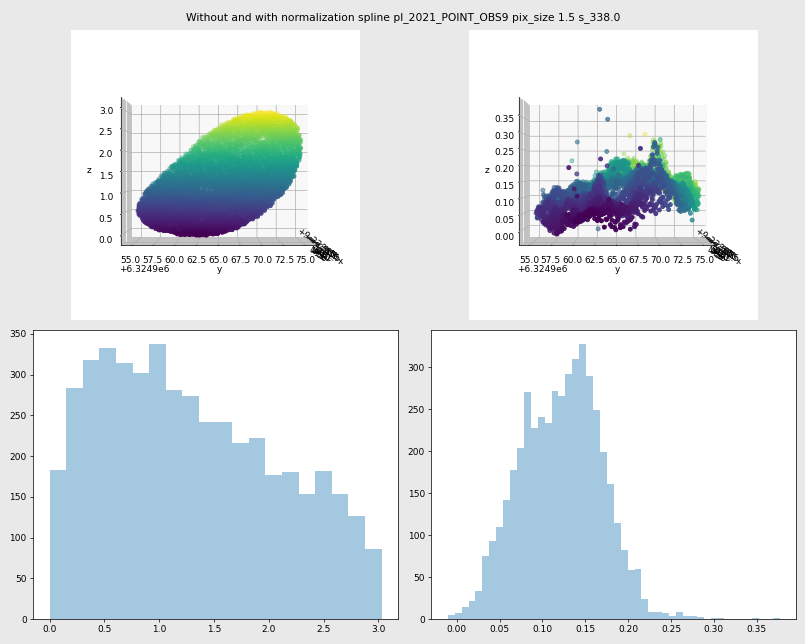

Without and with normalization spline pl_2021_POINT_OBS6 pix_size 1.5 s_338.0


<IPython.core.display.Javascript object>


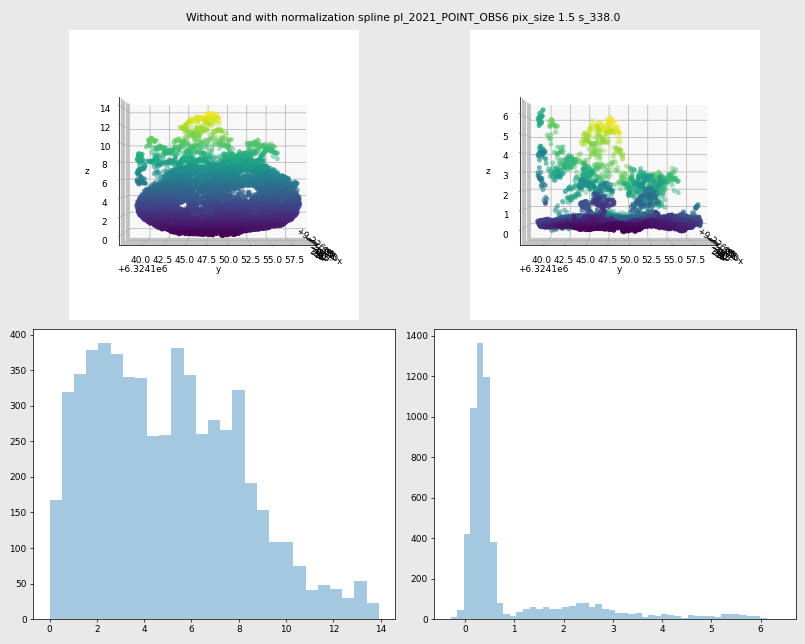

Without and with normalization spline pl_Releve_Lidar_F68 pix_size 1.5 s_338.0


<IPython.core.display.Javascript object>


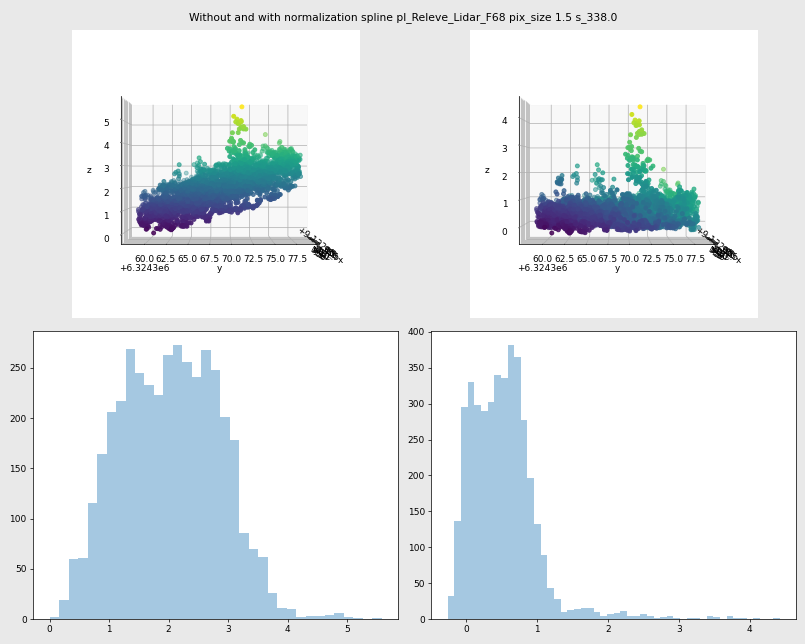

Without and with normalization spline pl_Releve_Lidar_F69 pix_size 1.5 s_338.0


<IPython.core.display.Javascript object>


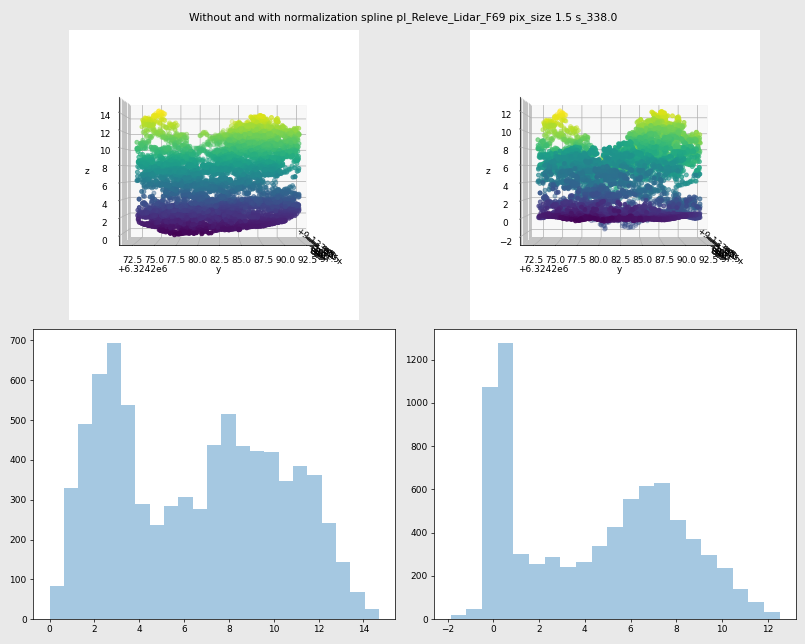

Without and with normalization spline pl_Releve_Lidar_F20 pix_size 1.5 s_338.0


<IPython.core.display.Javascript object>


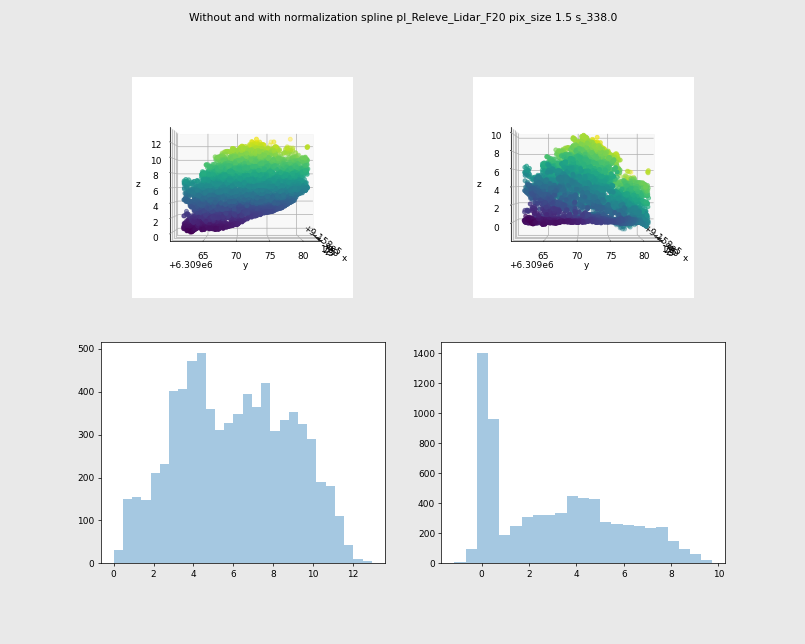

KeyboardInterrupt: 

In [42]:
pix_size = 1.5
s = (20//pix_size)**2 * 2

for name, my_cloud in selection.items():
    cloud = my_cloud.copy()    
    output_path = f"./temp/spline_norm_impact_pl_{name}_pix_size_{pix_size}_s_{s}.png"
    cloud_norm = normalize_z_with_smooth_spline(cloud, pix_size, s=s)
    title = f"Without and with normalization spline pl_{name} pix_size {pix_size} s_{s}"
    print(title)
    plot_norm_impact(cloud, cloud_norm, title, output_path)

## Comparison of methods

<IPython.core.display.Javascript object>


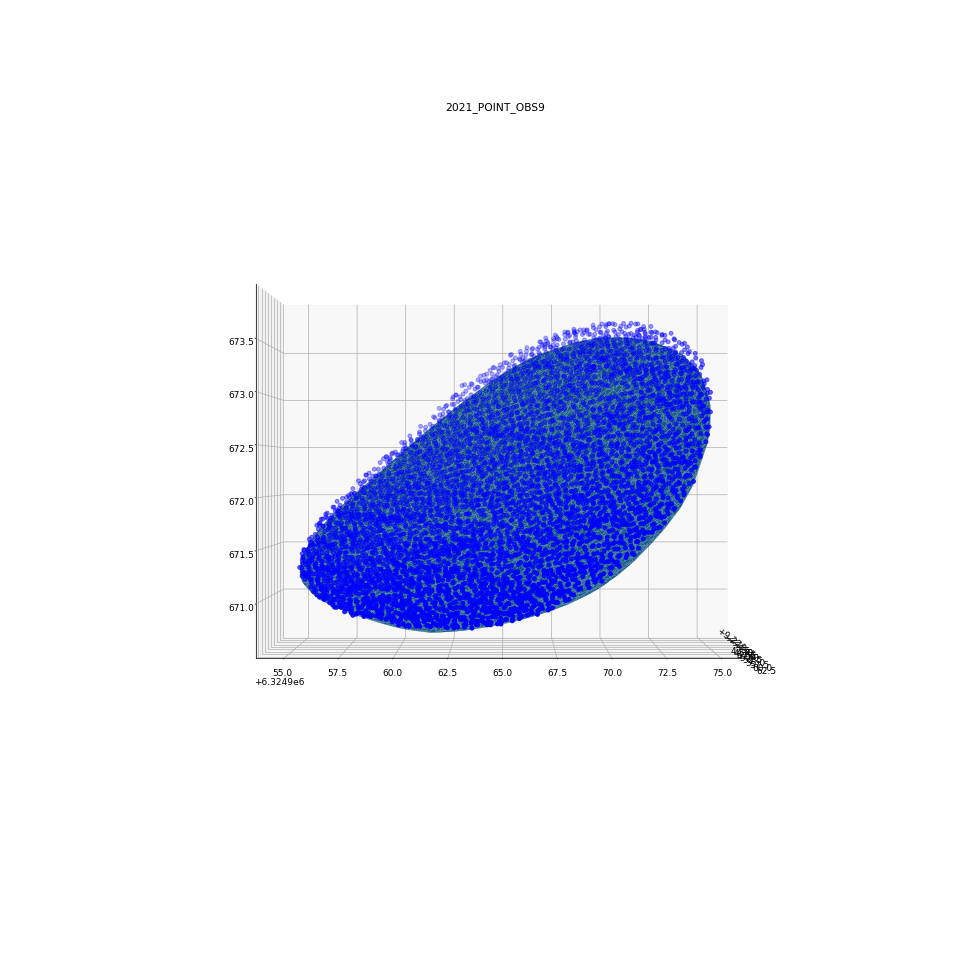

<IPython.core.display.Javascript object>


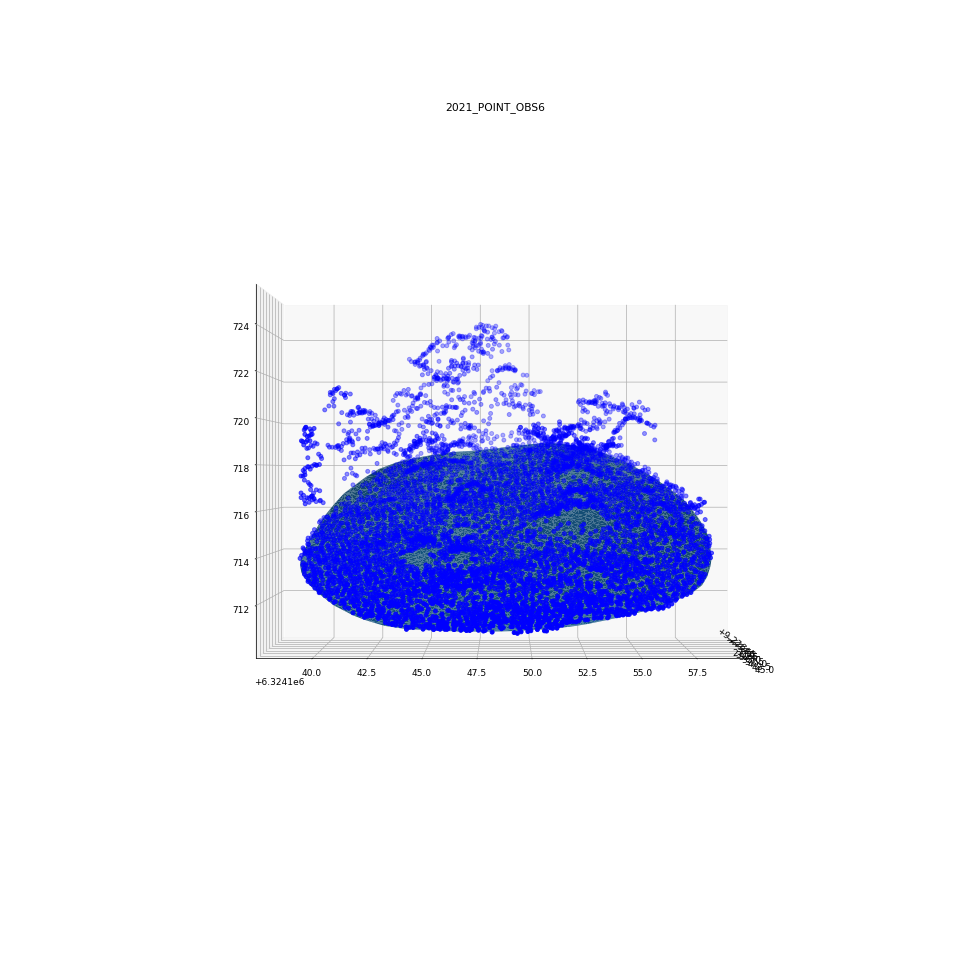

<IPython.core.display.Javascript object>


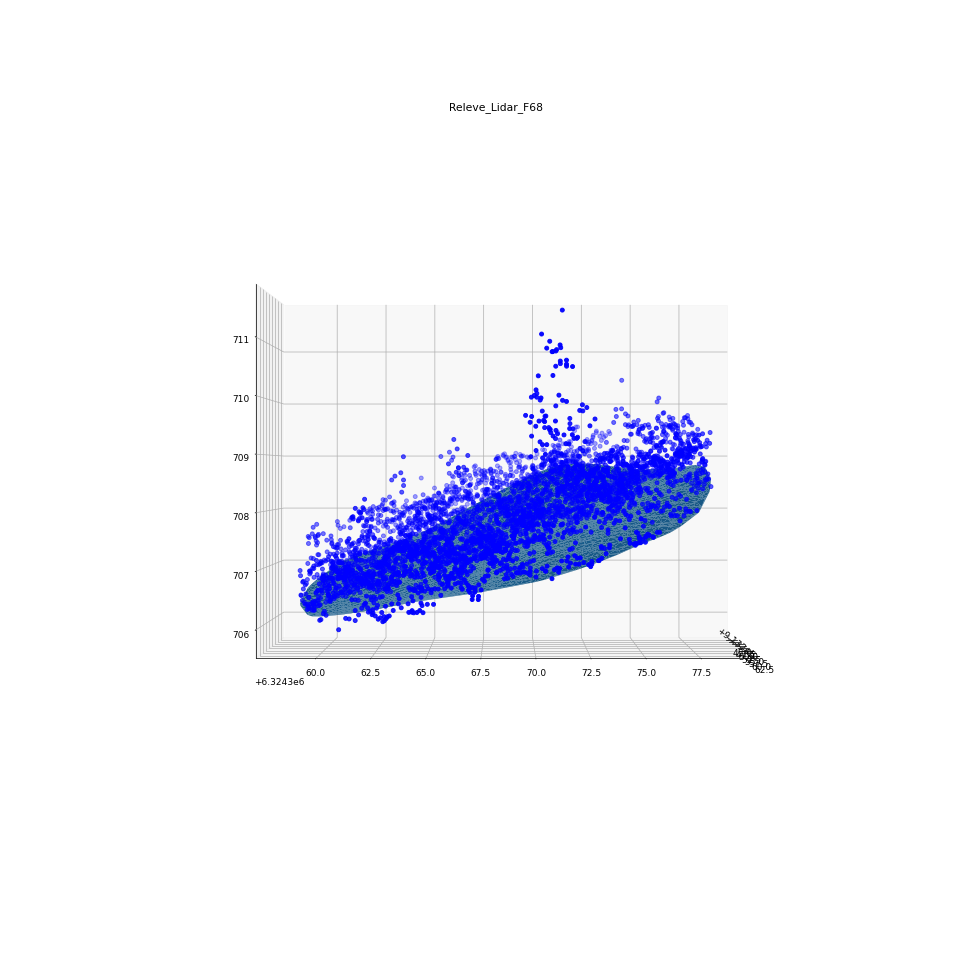

<IPython.core.display.Javascript object>


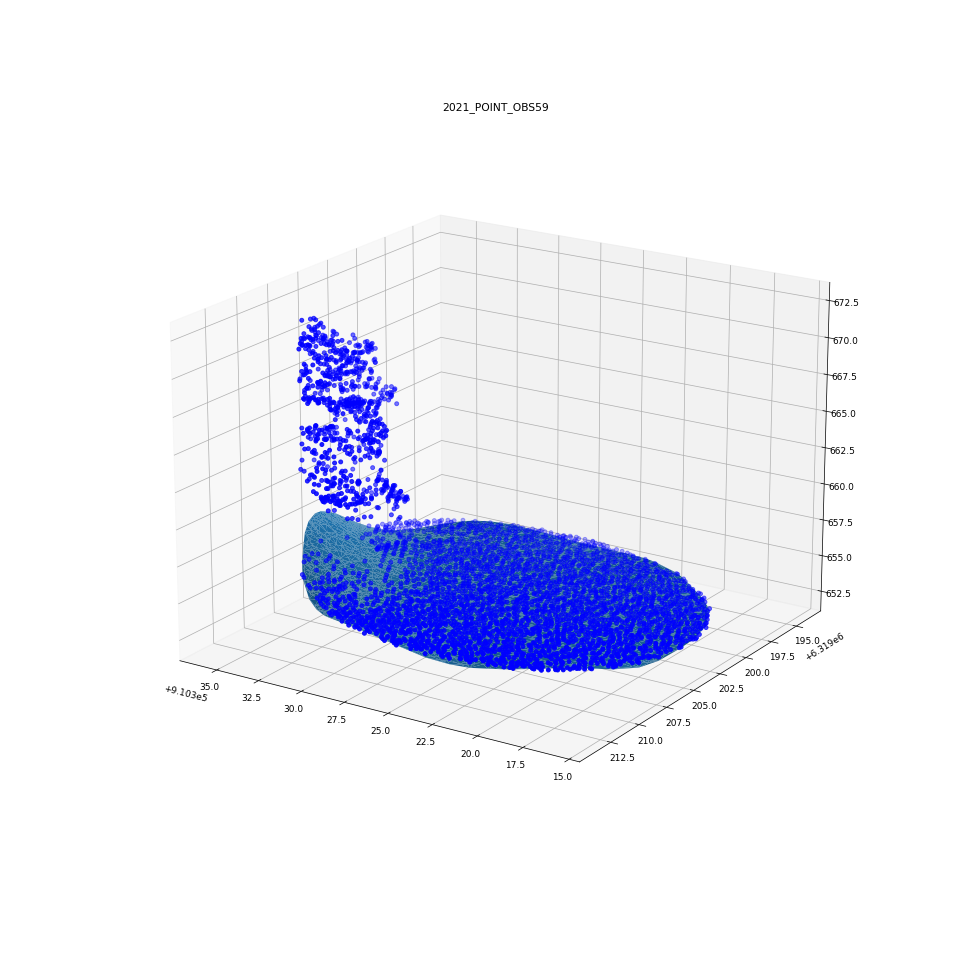

<IPython.core.display.Javascript object>


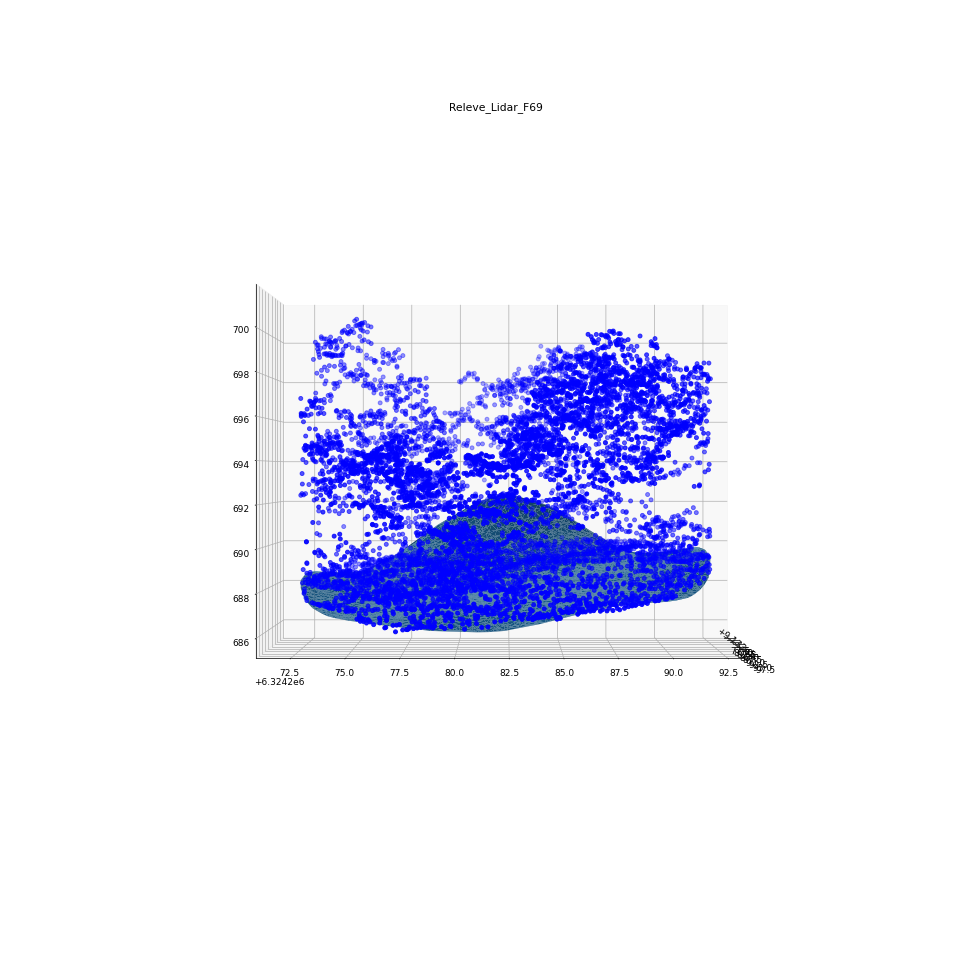

<IPython.core.display.Javascript object>


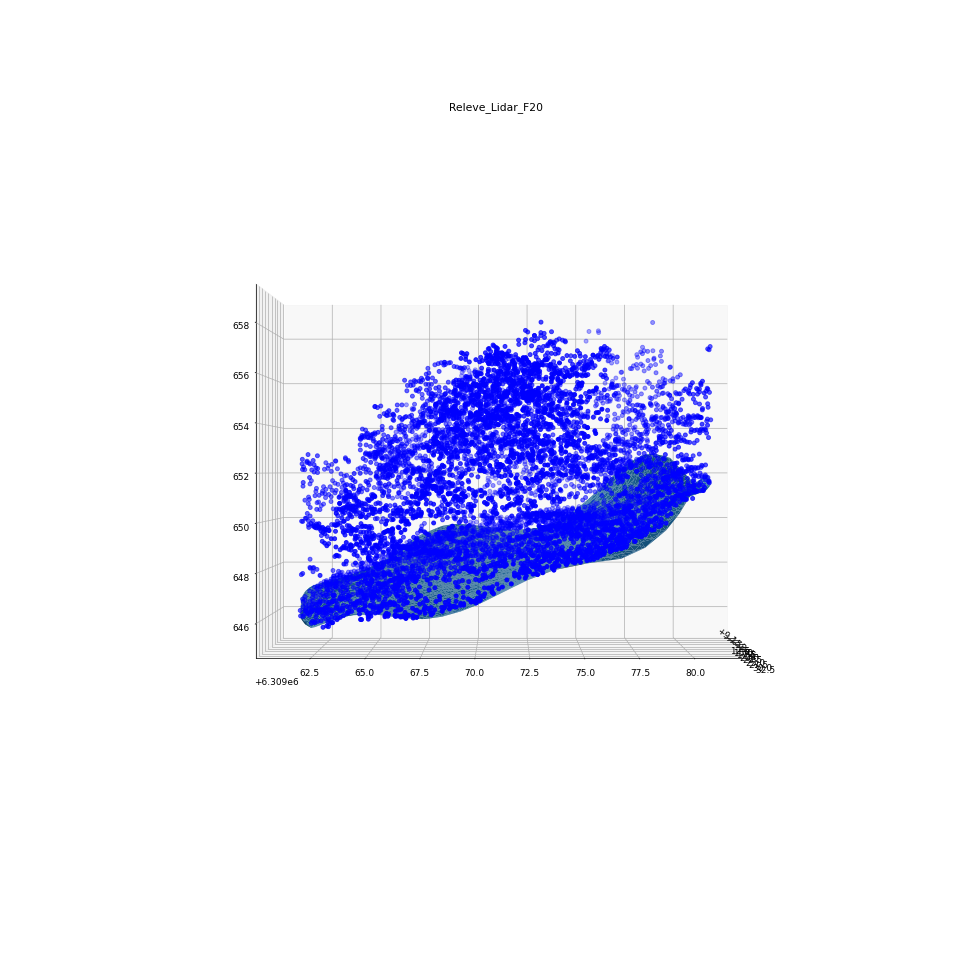

<IPython.core.display.Javascript object>


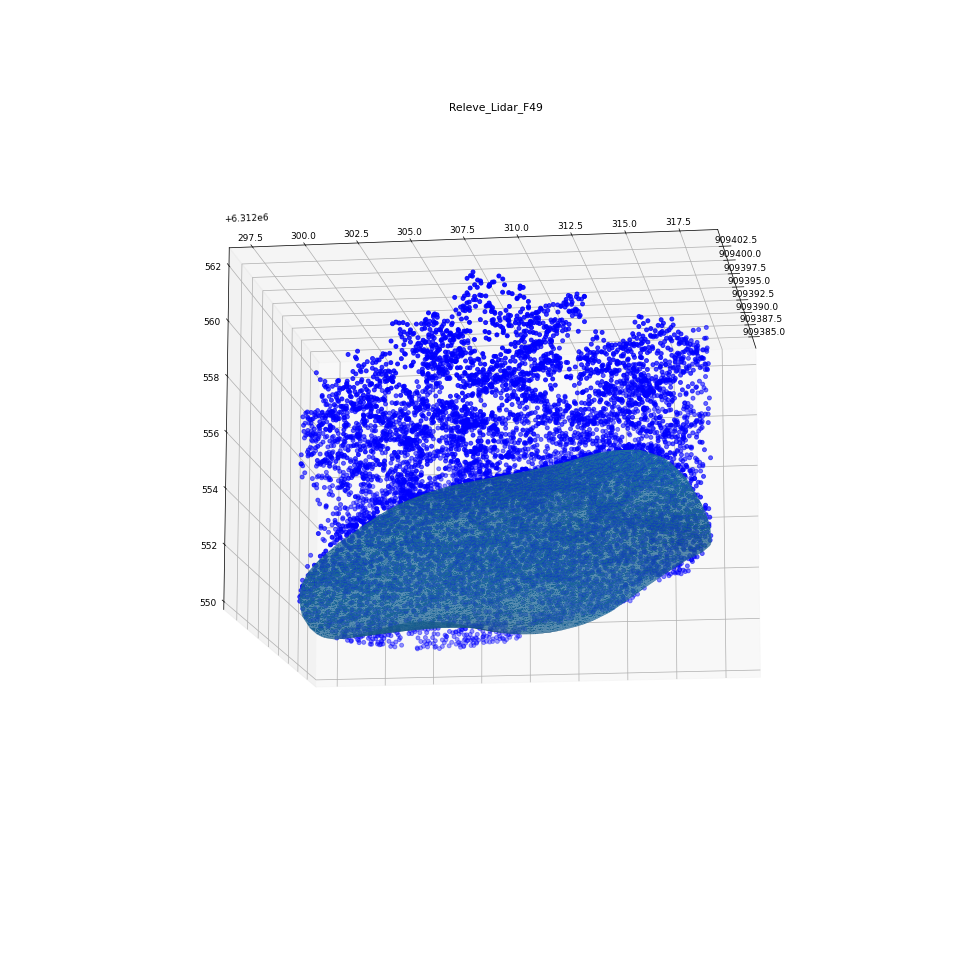

In [58]:
%matplotlib notebook
def visualize_spline_approx(cloud, title):
    norm_cloud = normalize_z_with_smooth_spline(cloud, 1.5)
    cloud_dtm = norm_cloud.copy()
    cloud_dtm[:,2] = cloud[:,2] - cloud_dtm[:,2]

    # Visualize
    plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(cloud_dtm[:,0], cloud_dtm[:,1], cloud_dtm[:,2]);
    ax.scatter3D(cloud[:,0], cloud[:,1], cloud[:,2], c= "b", cmap='Greens');
    ax.view_init(elev=0., azim=0)
#     ax.set_zlim(-5, 5)
    plt.title(title)
    plt.show()


for key in selection:
    visualize_spline_approx(selection[key], key)
pass

<IPython.core.display.Javascript object>


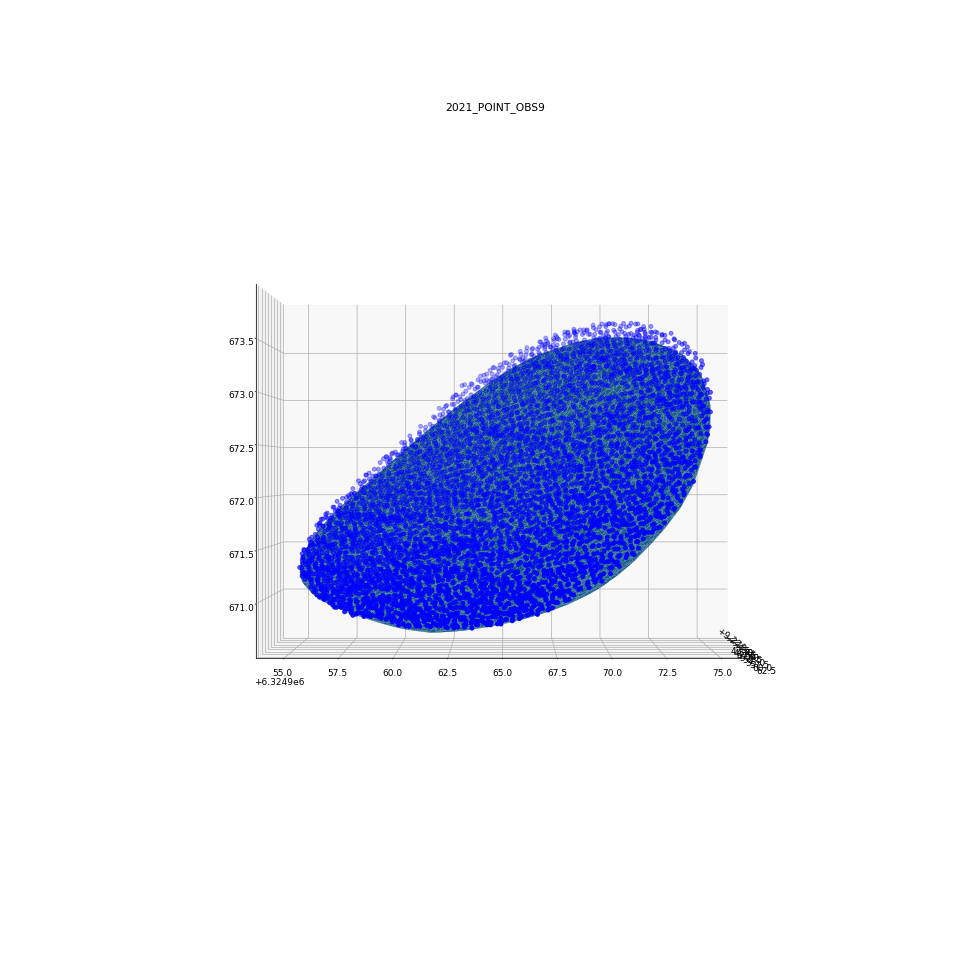

<IPython.core.display.Javascript object>


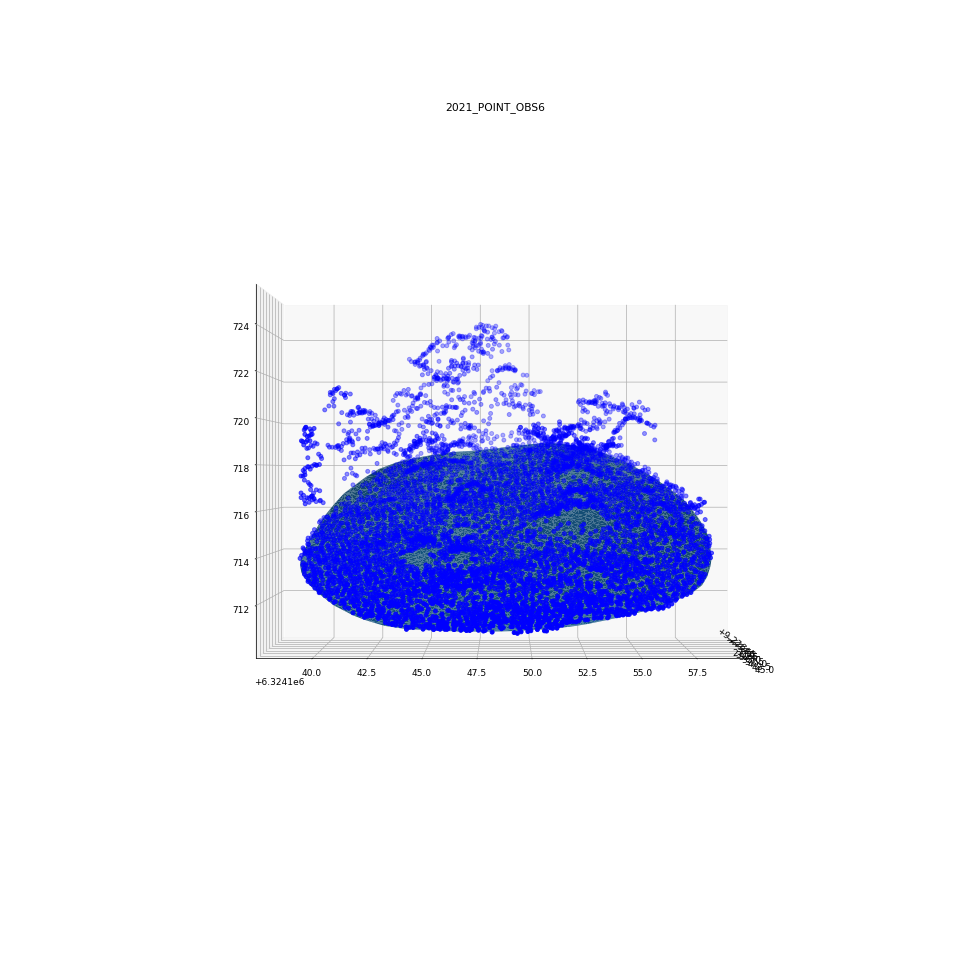

<IPython.core.display.Javascript object>


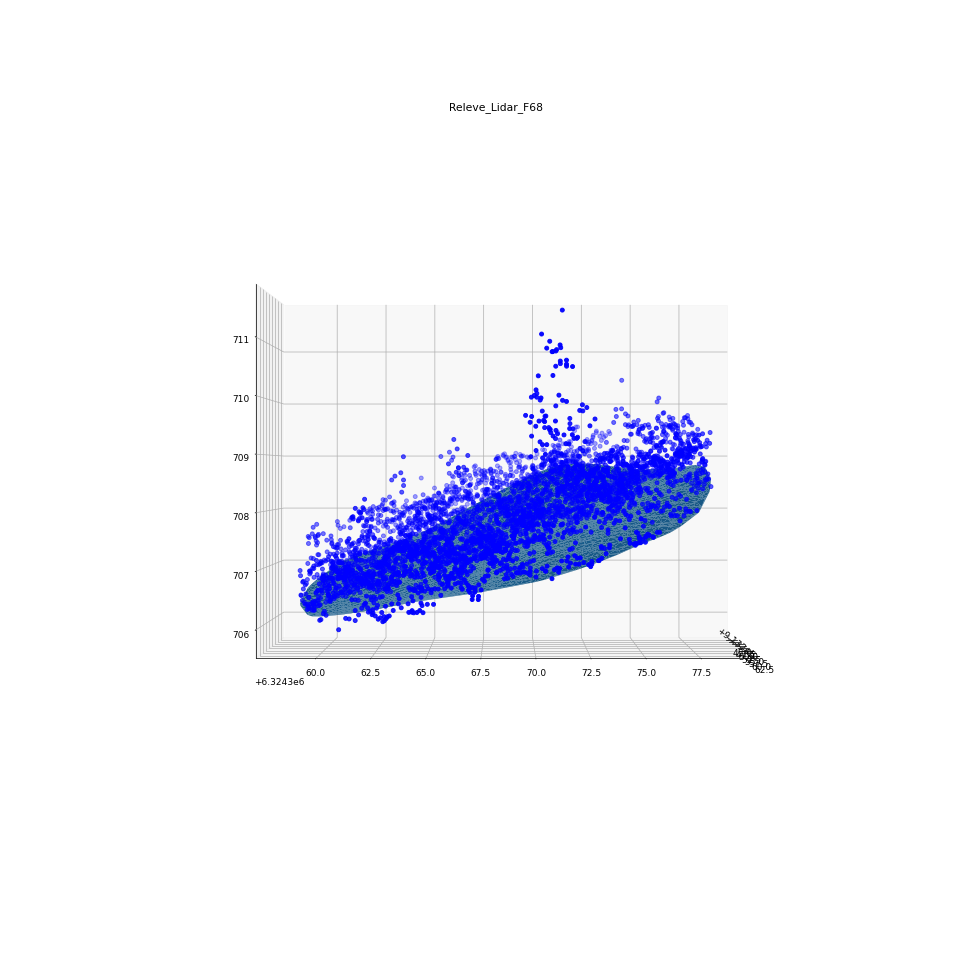

<IPython.core.display.Javascript object>


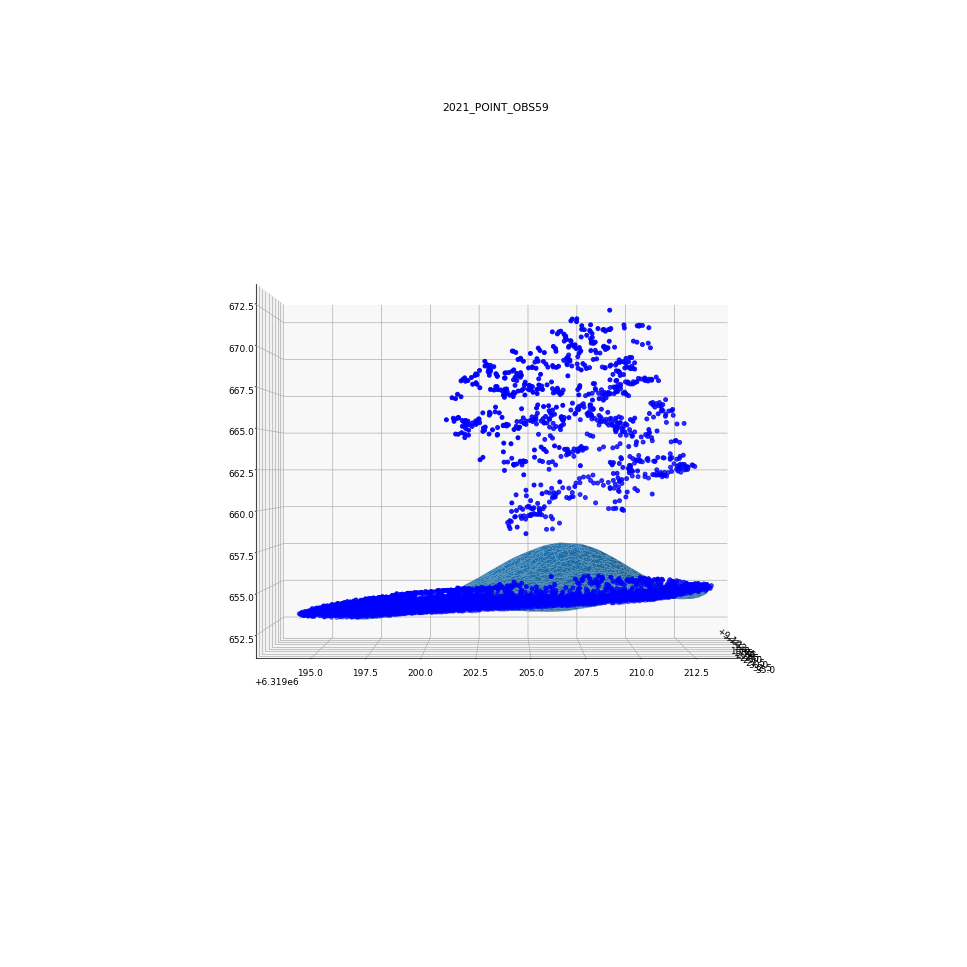

<IPython.core.display.Javascript object>


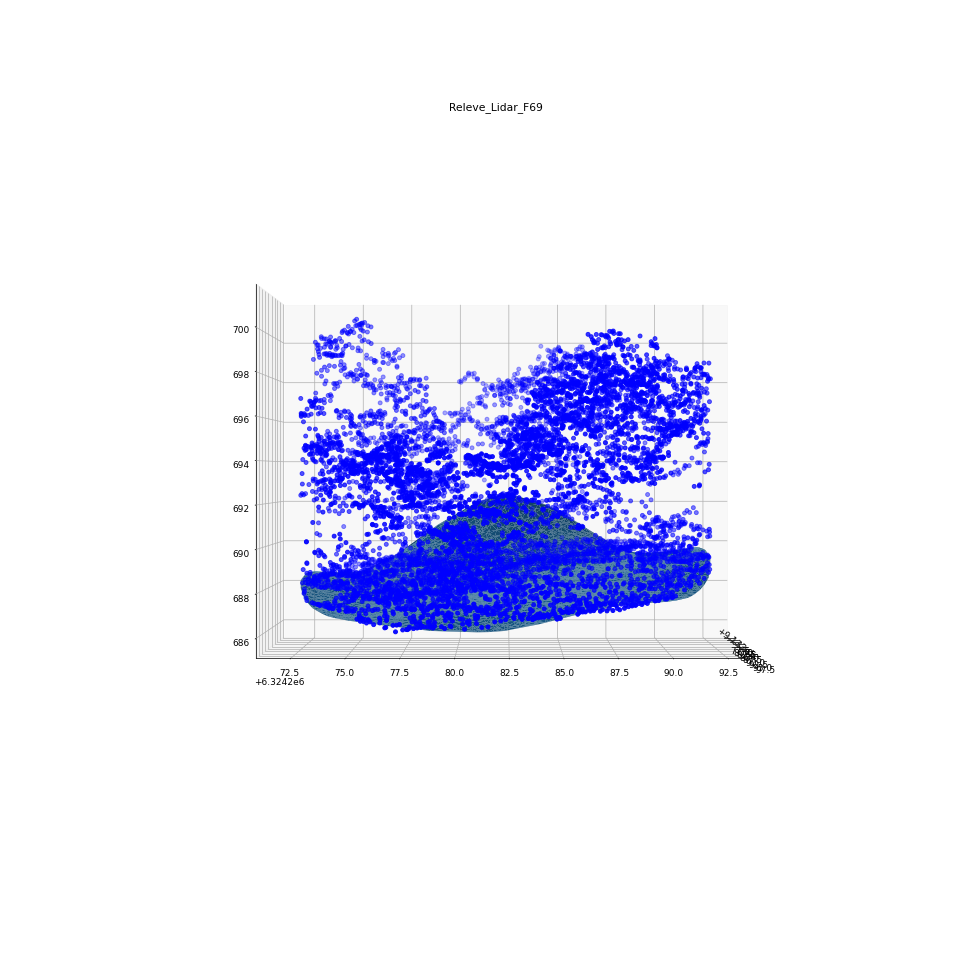

<IPython.core.display.Javascript object>


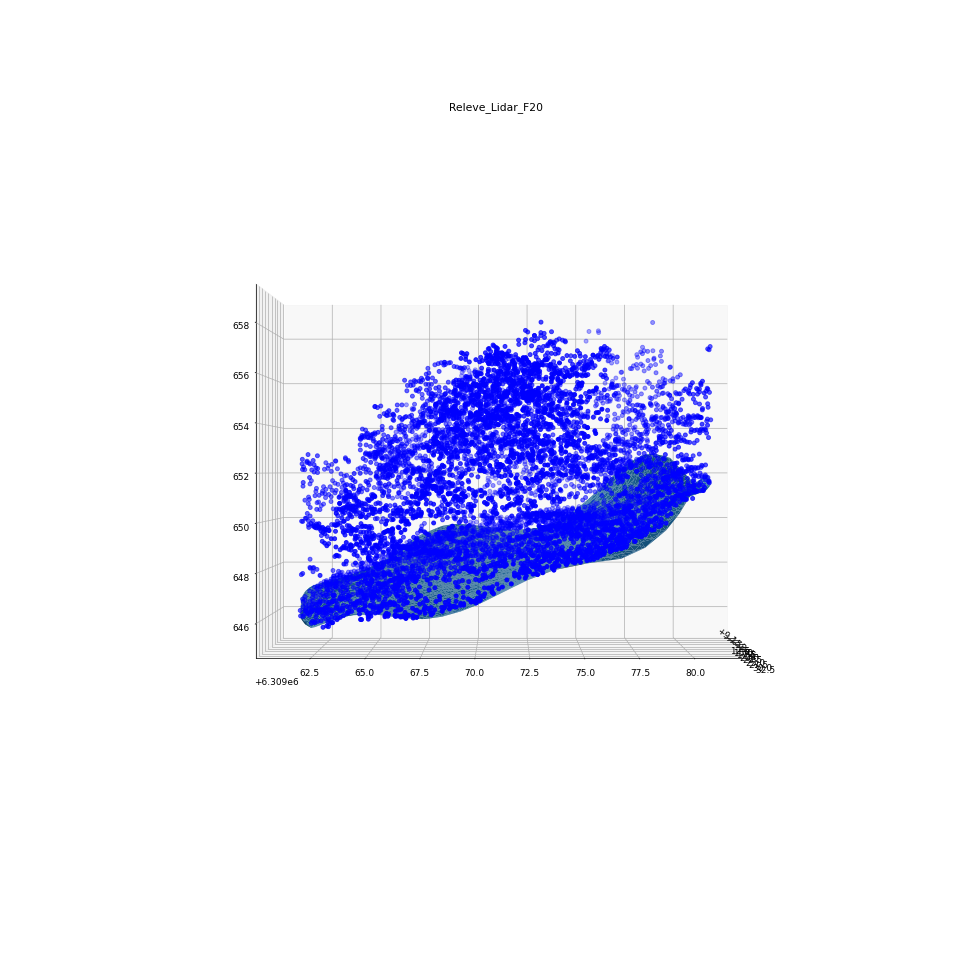

<IPython.core.display.Javascript object>


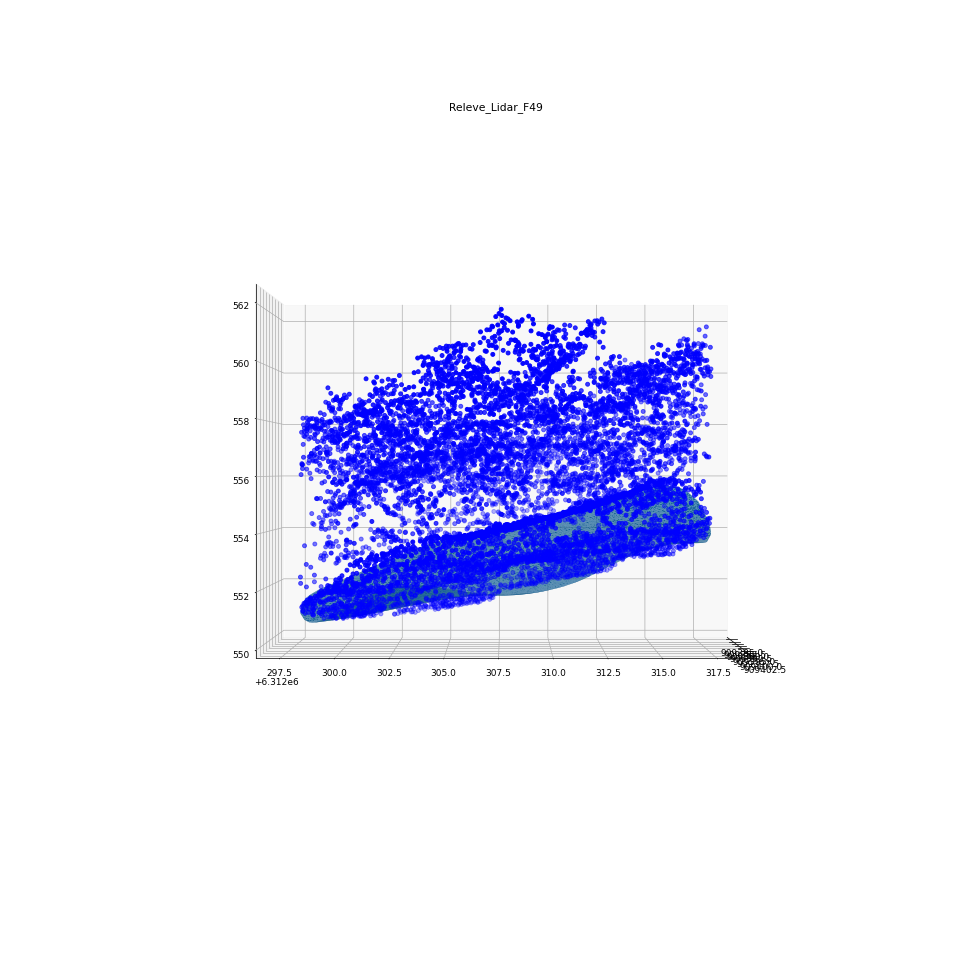

In [61]:
%matplotlib notebook
def visualize_znorm_approx(cloud, title):
    norm_cloud = normalize_z_with_minz_in_a_radius(cloud, 1.5)
    cloud_dtm = norm_cloud.copy()
    cloud_dtm[:,2] = cloud[:,2] - cloud_dtm[:,2]

    # Visualize
    plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(cloud_dtm[:,0], cloud_dtm[:,1], cloud_dtm[:,2]);
    ax.scatter3D(cloud[:,0], cloud[:,1], cloud[:,2], c= "b", cmap='Greens');
    ax.view_init(elev=0., azim=0)
#     ax.set_zlim(-5, 5)
    plt.title(title)
    plt.show()


for key in selection:
    visualize_spline_approx(selection[key], key)
pass

## Try 2 with real data and normXcm (varying X)

Select clouds

In [18]:
nparray_clouds_dict = load_my_data()
selection = select_my_clouds()

In [19]:
# OERWRITE HERE
def normalize_z_with_minz_in_a_radius(points_placette, znorm_radius_in_meters, n_neighboors):
    # # We directly substract z_min at local level
    xyz = points_placette[:, :3]
    knn = NearestNeighbors(n_neighboors, algorithm="kd_tree").fit(xyz[:, :2])
    _, neigh = knn.radius_neighbors(xyz[:, :2], znorm_radius_in_meters)
    z = xyz[:, 2]
    zmin_neigh = []
    for n in range(
        len(z)
    ):  # challenging to make it work without a loop as neigh has different length for each point
        zmin_neigh.append(np.min(z[neigh[n]]))
    points_placette[:, 2] = points_placette[:, 2] - zmin_neigh
    return points_placette

In [24]:
for name, my_cloud in selection.items():
    cloud = my_cloud.copy()
    # range_radius = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5, 6]
    range_radius = np.arange(0.25,5,0.25)
    for radius_in_meters in range_radius:
        output_path = f"./temp/radius_norm_impact_pl_{name}_{radius_in_meters:.2f}.png"
        cloud_norm = normalize_z_with_minz_in_a_radius(cloud.copy(), radius_in_meters, n_neighboors)
        title = f"Without and with normalization (radius = {radius_in_meters:.2f}m)"
        print(title)
        plot_norm_impact(cloud, cloud_norm, title, output_path)

Without and with normalization (radius = 0.25m, n_neighboors=500)
Without and with normalization (radius = 0.25m, n_neighboors=1500)
Without and with normalization (radius = 0.50m, n_neighboors=500)
Without and with normalization (radius = 0.50m, n_neighboors=1500)
Without and with normalization (radius = 0.75m, n_neighboors=500)
Without and with normalization (radius = 0.75m, n_neighboors=1500)
Without and with normalization (radius = 1.00m, n_neighboors=500)
Without and with normalization (radius = 1.00m, n_neighboors=1500)
Without and with normalization (radius = 1.25m, n_neighboors=500)
Without and with normalization (radius = 1.25m, n_neighboors=1500)
Without and with normalization (radius = 1.50m, n_neighboors=500)
Without and with normalization (radius = 1.50m, n_neighboors=1500)
Without and with normalization (radius = 1.75m, n_neighboors=500)
Without and with normalization (radius = 1.75m, n_neighboors=1500)
Without and with normalization (radius = 2.00m, n_neighboors=500)
Wit

Without and with normalization (radius = 1.50m, n_neighboors=500)
Without and with normalization (radius = 1.50m, n_neighboors=1500)
Without and with normalization (radius = 1.75m, n_neighboors=500)
Without and with normalization (radius = 1.75m, n_neighboors=1500)
Without and with normalization (radius = 2.00m, n_neighboors=500)
Without and with normalization (radius = 2.00m, n_neighboors=1500)
Without and with normalization (radius = 2.25m, n_neighboors=500)
Without and with normalization (radius = 2.25m, n_neighboors=1500)
Without and with normalization (radius = 2.50m, n_neighboors=500)
Without and with normalization (radius = 2.50m, n_neighboors=1500)
Without and with normalization (radius = 2.75m, n_neighboors=500)
Without and with normalization (radius = 2.75m, n_neighboors=1500)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f520e089b80> (for post_execute):


KeyboardInterrupt: 

In [21]:
output_path

'./temp_norm/radius_norm_impact_pl_Releve_Lidar_F69_4.75.png'

<IPython.core.display.Javascript object>


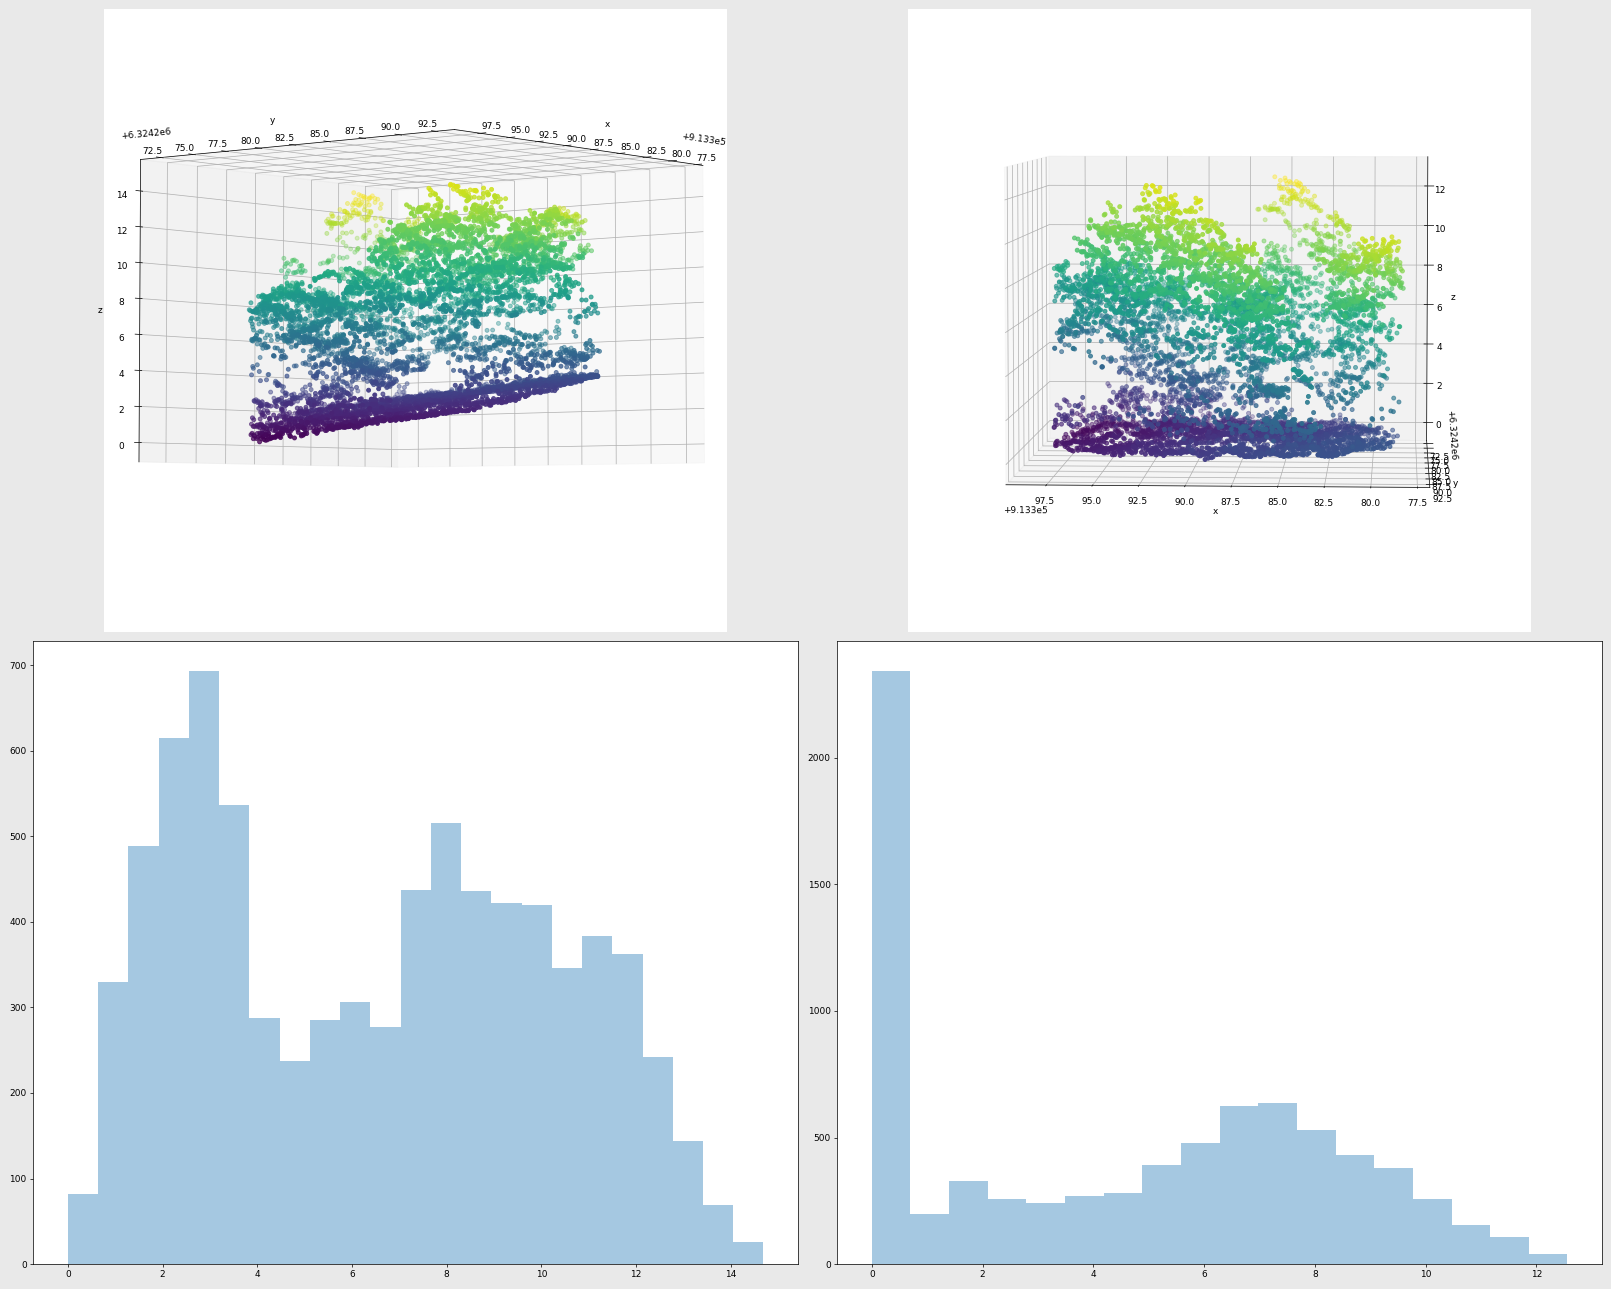

In [22]:
%matplotlib notebook
cloud_norm = normalize_z_with_minz_in_a_radius(cloud.copy(), 1.5)

cloud[:,2] = cloud[:,2] - np.min(cloud[:,2])

fig = plt.figure(figsize=plt.figaspect(0.8) * 5)
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
# fig.suptitle(title)

# without norm
ax = fig.add_subplot(2, 2, 1, projection="3d")
ax.scatter3D(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=cloud[:, 2] + 0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=0., azim=0)

ax = fig.add_subplot(2, 2, 3)
sns.distplot(cloud[:,2],ax=ax, kde=False)


# with norm
ax = fig.add_subplot(2, 2, 2, projection="3d")
ax.scatter3D(cloud_norm[:, 0], cloud_norm[:, 1], cloud_norm[:, 2], c=cloud[:, 2] + 0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=0., azim=0)

ax = fig.add_subplot(2, 2, 4)
sns.distplot(cloud_norm[:,2],ax=ax, kde=False)

plt.tight_layout()

In [21]:
# xy are in meters so we set step in meter
resolution = 2
F49[:3,:]//resolution

array([[ 454697., 3156154.,     276.],
       [ 454698., 3156155.,     276.],
       [ 454699., 3156155.,     277.]])

## Try 1 avec interp2d
-> no smooth 
-> need to use https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline

In [16]:
xy = np.random.random((1000, 2))
xy = (xy - xy.min(axis=0)) / (xy.max(axis=0) - xy.min(axis=0))
def fxy(x,y):
    return (-np.sin(y*2) + np.cos(x*2)*2 + 2*np.cos(x)*np.sin(x*2))
z = fxy(xy[:,0:1], xy[:,1:2])
xyz = np.append(xy,z, axis=1)

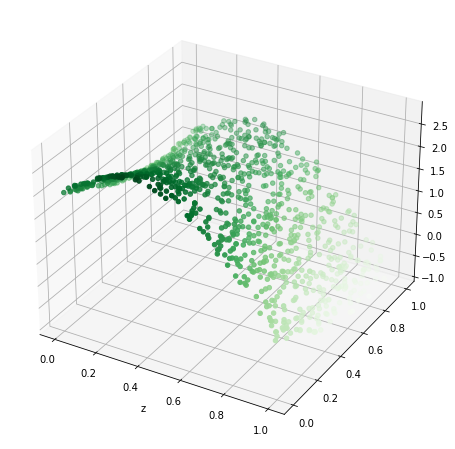

In [17]:
df = pd.DataFrame(xyz)
## TODO: change this to a specified number instead of meter precision ?
df.values[:, :2] = np.round(df.values[:, :2], 2)
df.columns = ["x", "y", "z"]

plt.figure(figsize=(8, 8))

ax = plt.axes(projection="3d")
ax.scatter3D(
    df.values[:, 0], df.values[:, 1], df.values[:, 2], c=df.values[:, 2], cmap="Greens"
)
plt.xlabel("x")
plt.xlabel("z")
plt.show()

/home/CGaydon/anaconda3/envs/lidar_pac/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=35,31 m=1000 fp=299156.720735 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


(-5.0, 5.0)

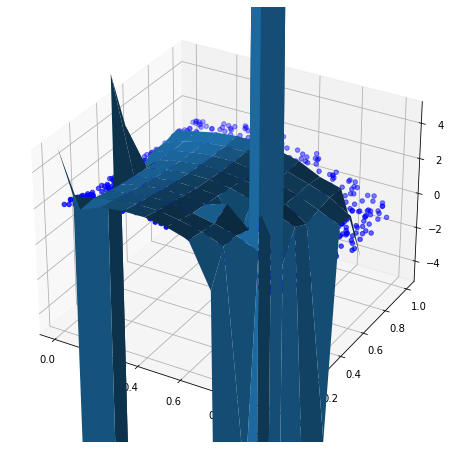

In [22]:
# Learn the approximate DTM
# Linar interpolation is more robust that cubic on the edges.

xzmin = df.groupby(["x","y"])["z"].min()+0.5
xzmin = xzmin.reset_index()
f = interpolate.interp2d(df.values[:,0], df.values[:,1], df.values[:,2], kind='cubic')
x_steps = (np.arange(0, 1, 0.1))
y_steps = (np.arange(0, 1, 0.1))
zz_coord = f(x_steps,y_steps)

# xx_coord = xx.flatten()
# yy_coord = yy.flatten()
# cf. https://stackoverflow.com/questions/47087109/evaluate-the-output-from-scipy-2d-interpolation-along-a-curve
# zz_coord = interpolate.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], xx_coord, yy_coord)[0]


# Visualize
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
xx, yy = np.meshgrid(x_steps, y_steps)
ax.plot_surface(xx, yy, zz_coord);
ax.scatter3D(df.values[:,0], df.values[:,1], df.values[:,2], c= "b", cmap='Greens');
ax.set_zlim(-5, 5)

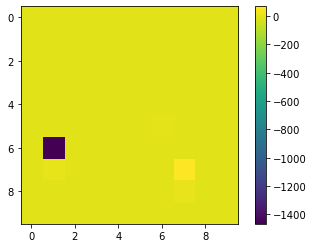

In [13]:
plt.imshow(zz_coord)
plt.colorbar()

In [7]:
# normalize
norm_z = Z - zz_coord

NameError: name 'Z' is not defined

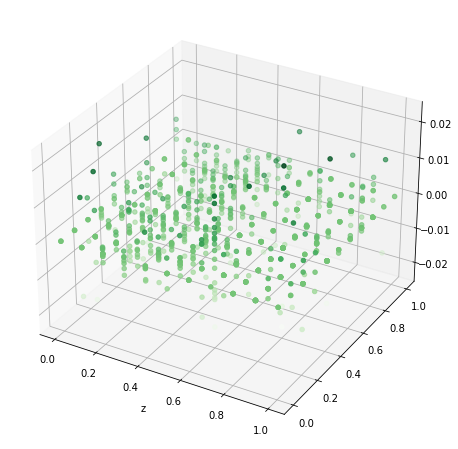

In [14]:
xyz_ = xyz.copy()
xyz_[:,2] = xyz[:,2] - interpolate.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], xyz[:,0], xyz[:,1])[0]
df = pd.DataFrame(xyz_)
## TODO: change this to a specified number instead of meter precision ?
df.values[:, :2] = np.round(df.values[:, :2], 1)
df.columns = ["x", "y", "z"]

plt.figure(figsize=(8, 8))

ax = plt.axes(projection="3d")
ax.scatter3D(
    df.values[:, 0], df.values[:, 1], df.values[:, 2], c=df.values[:, 2], cmap="Greens"
)
plt.xlabel("x")
plt.xlabel("z")
plt.show()

In [ ]:
# NEED FOR SMOOTHER INTERPOLATION s>0 in lass scipy.interpolate.RectBivariateSpline
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline